In [1]:
from pathlib import Path
from mea_flow.data import load_data

# Dataset configuration
data_path = '/media/neuro/Data/MEA-data/'
conditions = ['control', 'chronic-stress', 'miR-186-5p-inhibition']
filenames = ['n1-DIV17-01.mat', 'n2-DIV17-01.mat', 'n3-DIV17-01.mat']  # Use .mat files

# Load datasets into condition-based dictionary
spike_lists = {}

for condition, filename in zip(conditions, filenames):
    file_path = Path(data_path) / filename
    spike_lists[condition] = load_data(
        file_path=file_path,
        data_format='mat',
        channels_key='Channels',
        times_key='Times',
        time_unit='s'  # Times are already in seconds in the .mat file
    )

/home/neuro/repos/mea-flow/src/mea_flow/analysis/synchrony.py:19: UserWarning: PySpike not available. Some synchrony metrics will be disabled.
  warnings.warn("PySpike not available. Some synchrony metrics will be disabled.")
/home/neuro/repos/mea-flow/src/mea_flow/manifold/embedding.py:26: UserWarning: UMAP not available. UMAP embedding will be disabled.
  warnings.warn("UMAP not available. UMAP embedding will be disabled.")


# Activity Visualization

Here we demonstrate the plotting routines you can use to visualize population activity with the MEAPlotter class. The package includes a lot of useful visualizations and different parameters to tweak the plot types, which we will demonstrate below. 

#### Visualize population activity

Prior to the analyses done above, we can visualize the population spiking activity with a few convenient methods: as spike raster plots within a defined interval, as a timeseries of mean population rates, or as a spatial map of firing rates per electrode.

In [2]:
from mea_flow.visualization import MEAPlotter
import matplotlib.pyplot as plt

plotter = MEAPlotter()


##### 1. Raster Plot (`plot_raster`) and animated raster (`plot_raster_animated`)



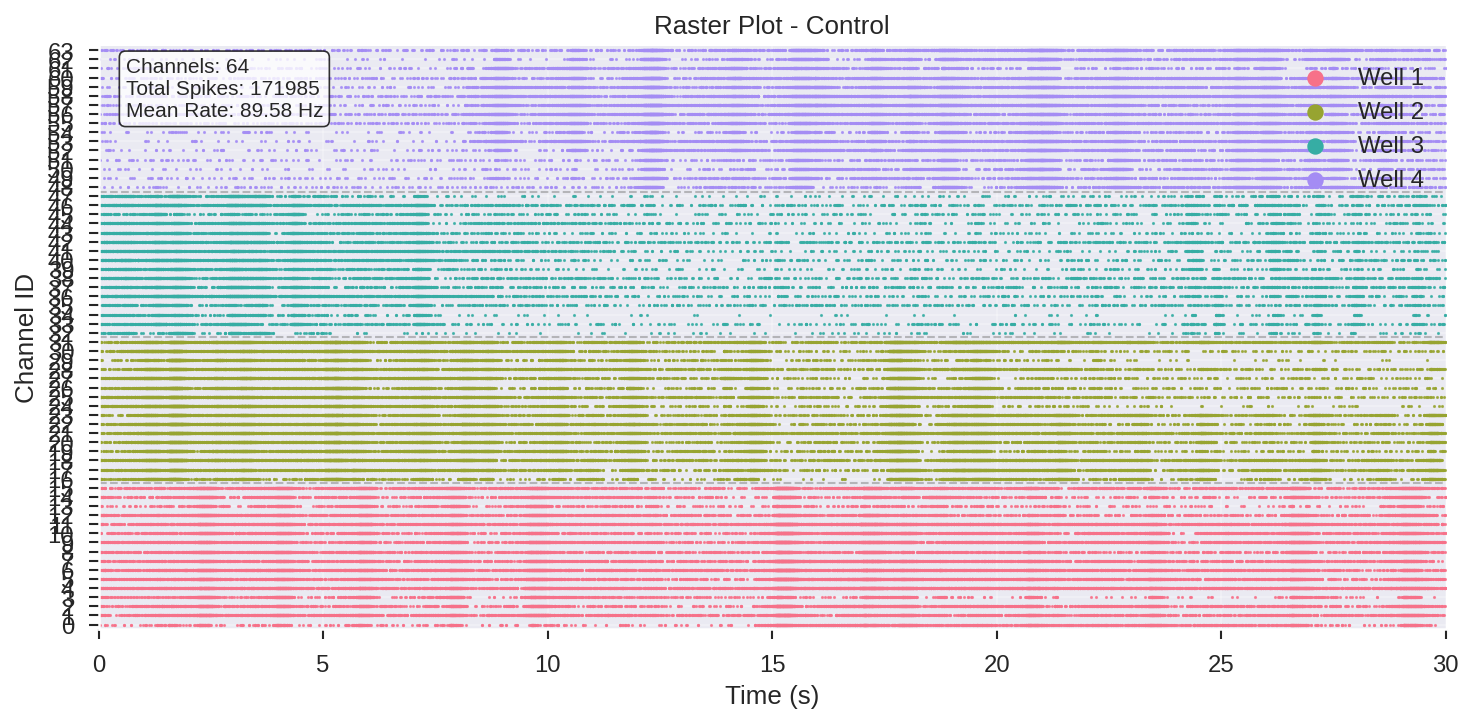

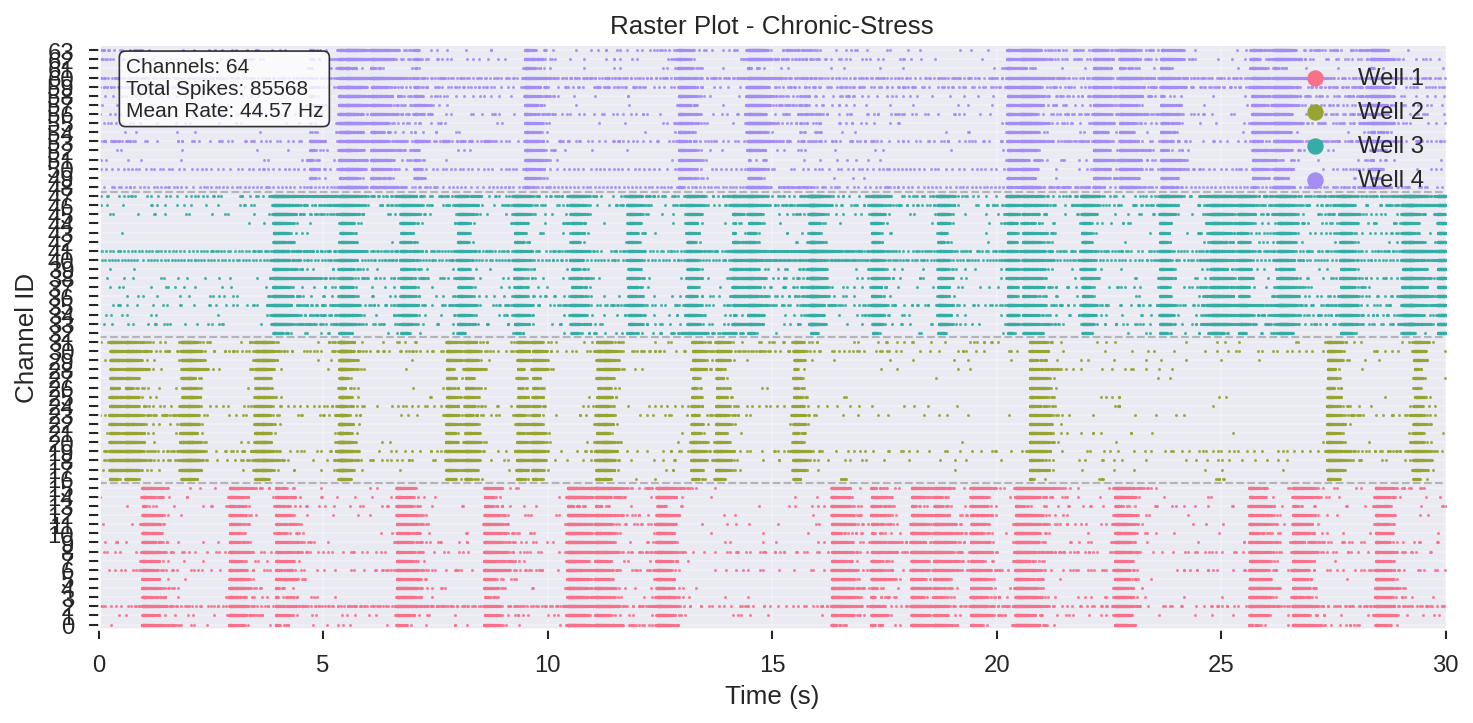

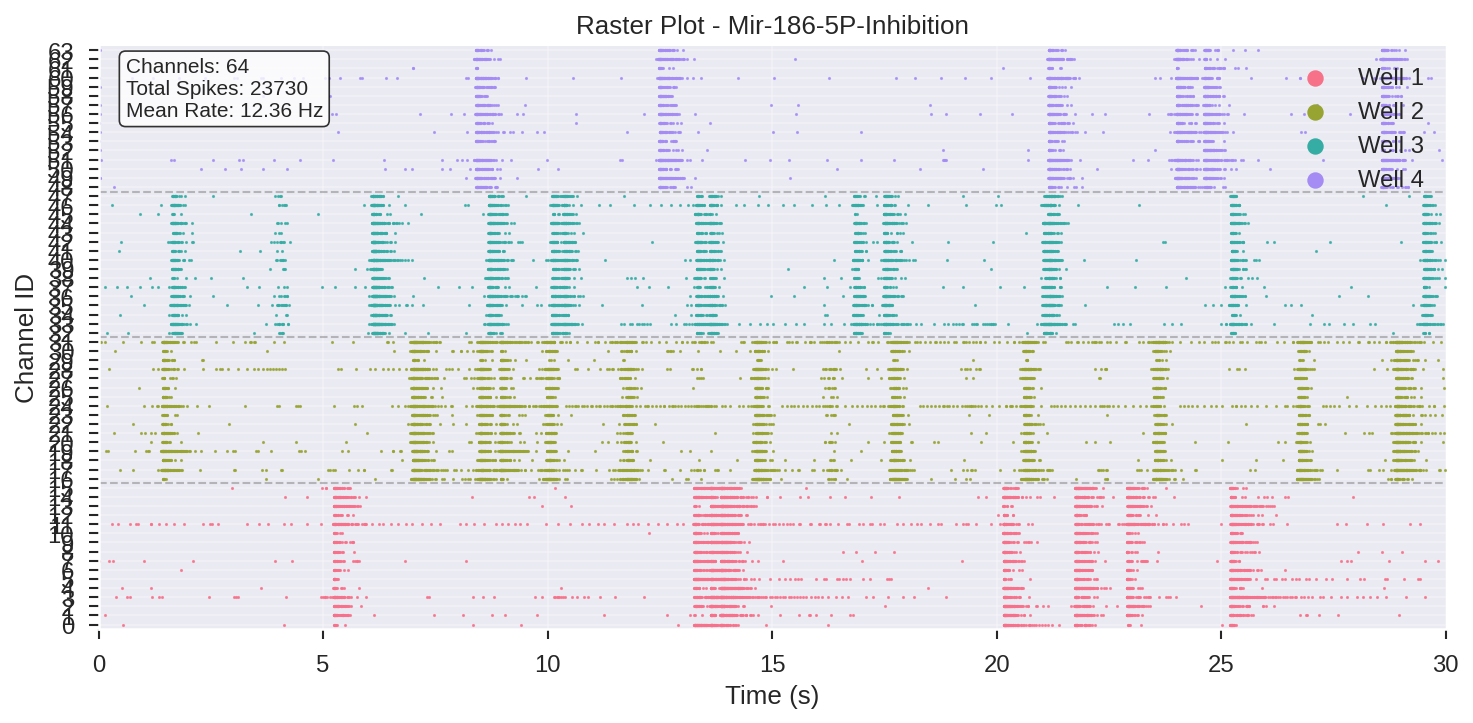

In [3]:
# Spike raster plot for individual conditions
for condition in conditions:
    fig = plotter.plot_raster(
        spike_lists[condition],
        time_range=(0, 30),  # First 30 seconds
        color_by_well=True,
        figsize=(10, 5),
        save_path=f'{condition}_raster.png'
    )
    plt.title(f'Raster Plot - {condition.title()}')
    plt.show()

In [4]:
# from mea_flow.visualization.raster import plot_animated_raster

# # Sliding window raster animation
# anim = plot_animated_raster(
#     spike_lists['miR-186-5p-inhibition'],
#     window_length=10.0,  # 10-second sliding window
#     step_size=0.5,       # Move 0.5s per frame
#     interval=50,        # 200ms between frames
#     save_path='raster_animation.mp4'  # Requires ffmpeg
# )

##### 2. Well activity PSTH (`plot_well_activity`)

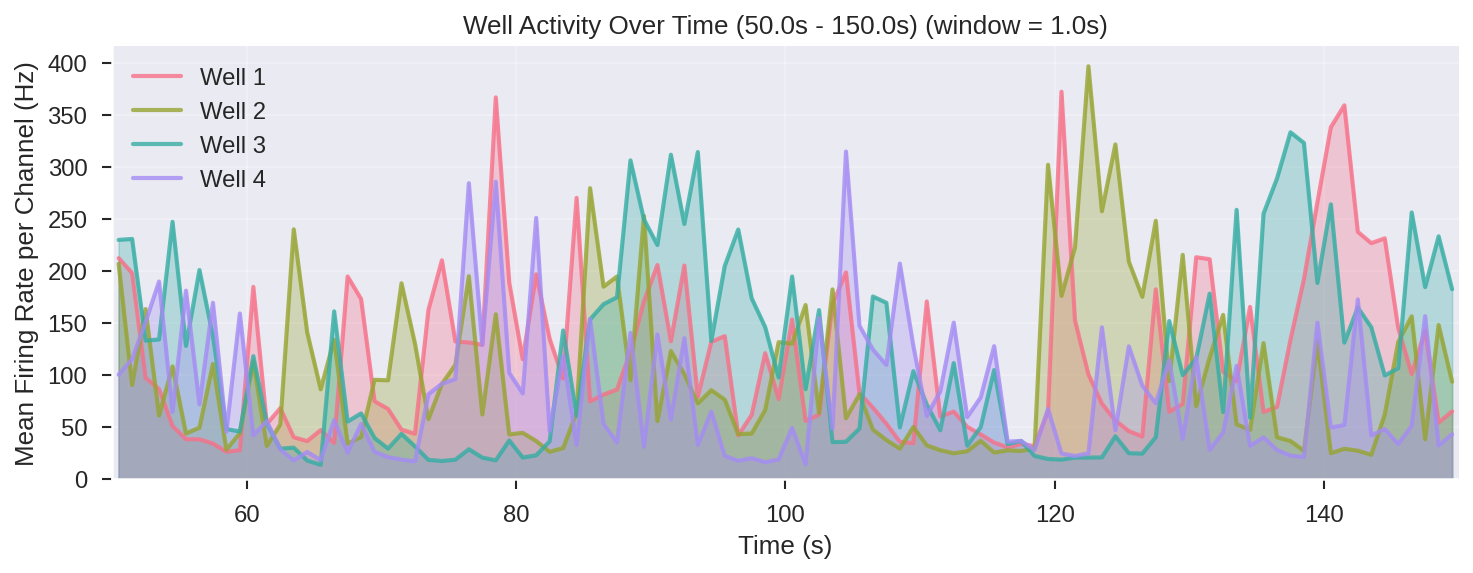

In [5]:
plotter.plot_well_activity(
    spike_lists['control'],
    metric='mean_rate',
    time_window=1.0,
    time_range=(50, 150), 
    figsize=(10, 4),
    separate_wells=False
)

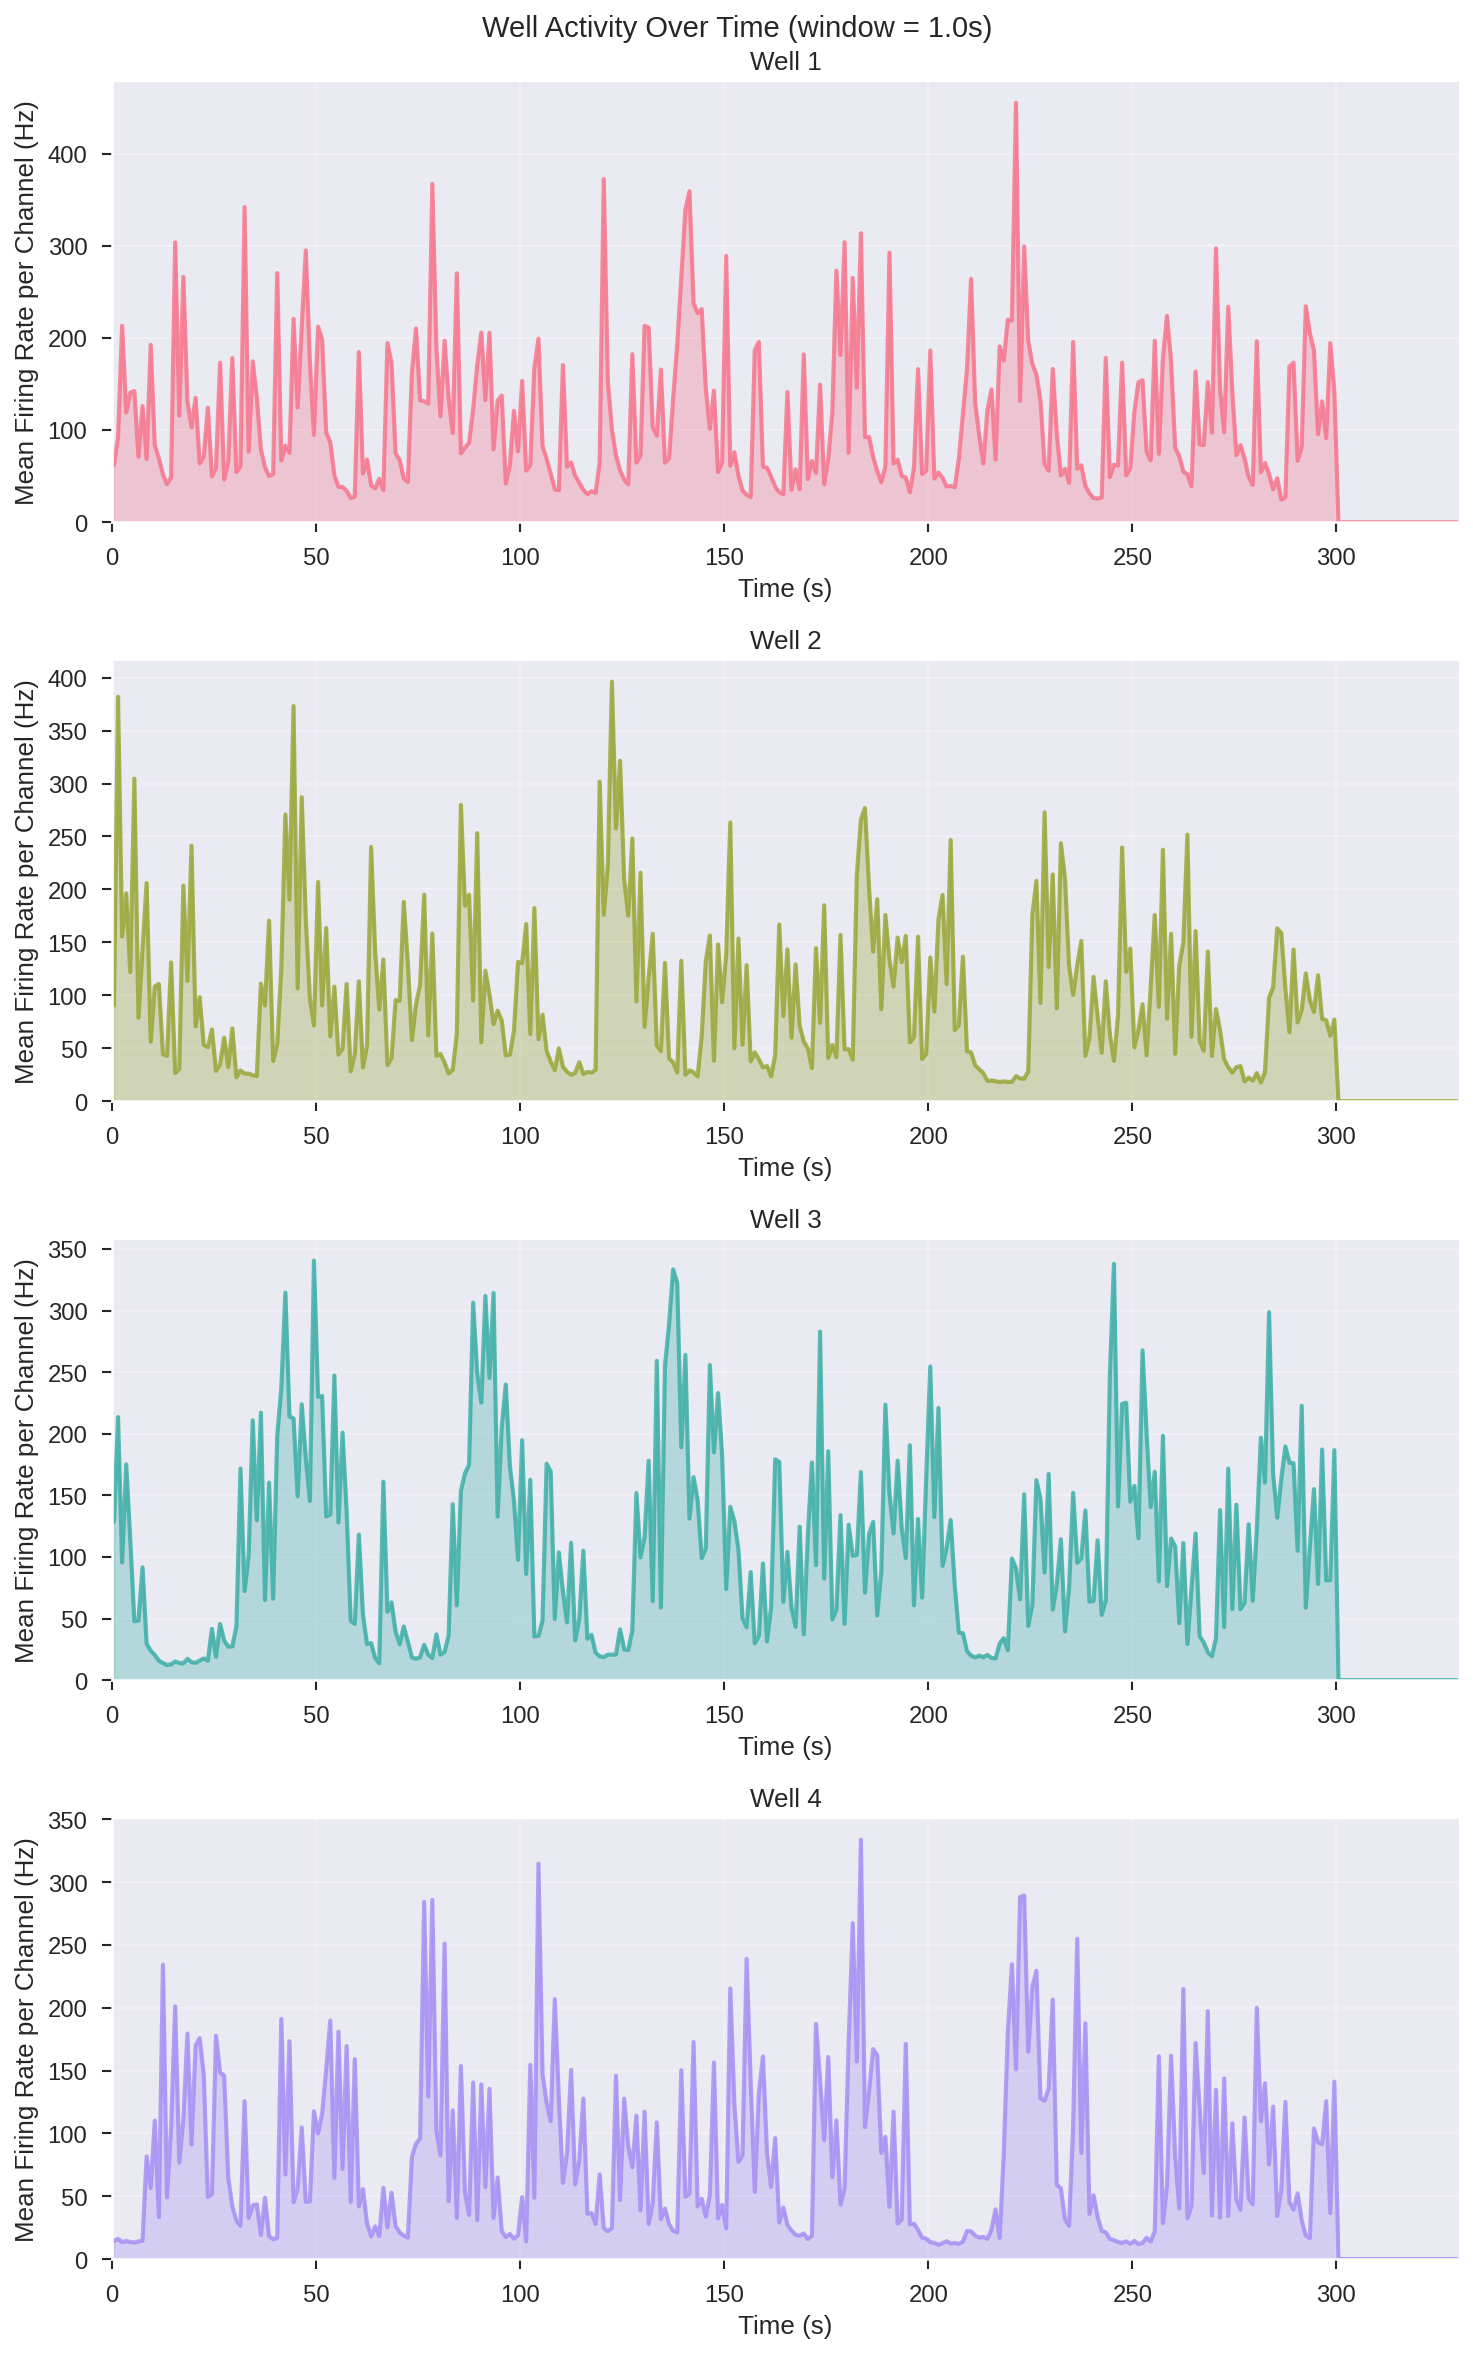

In [6]:
# Compare wells side-by-side
plotter.plot_well_activity(
    spike_lists['control'],
    metric='mean_rate',
    time_window=1.0,
    # time_range=(50, 150), 
    separate_wells=True
)

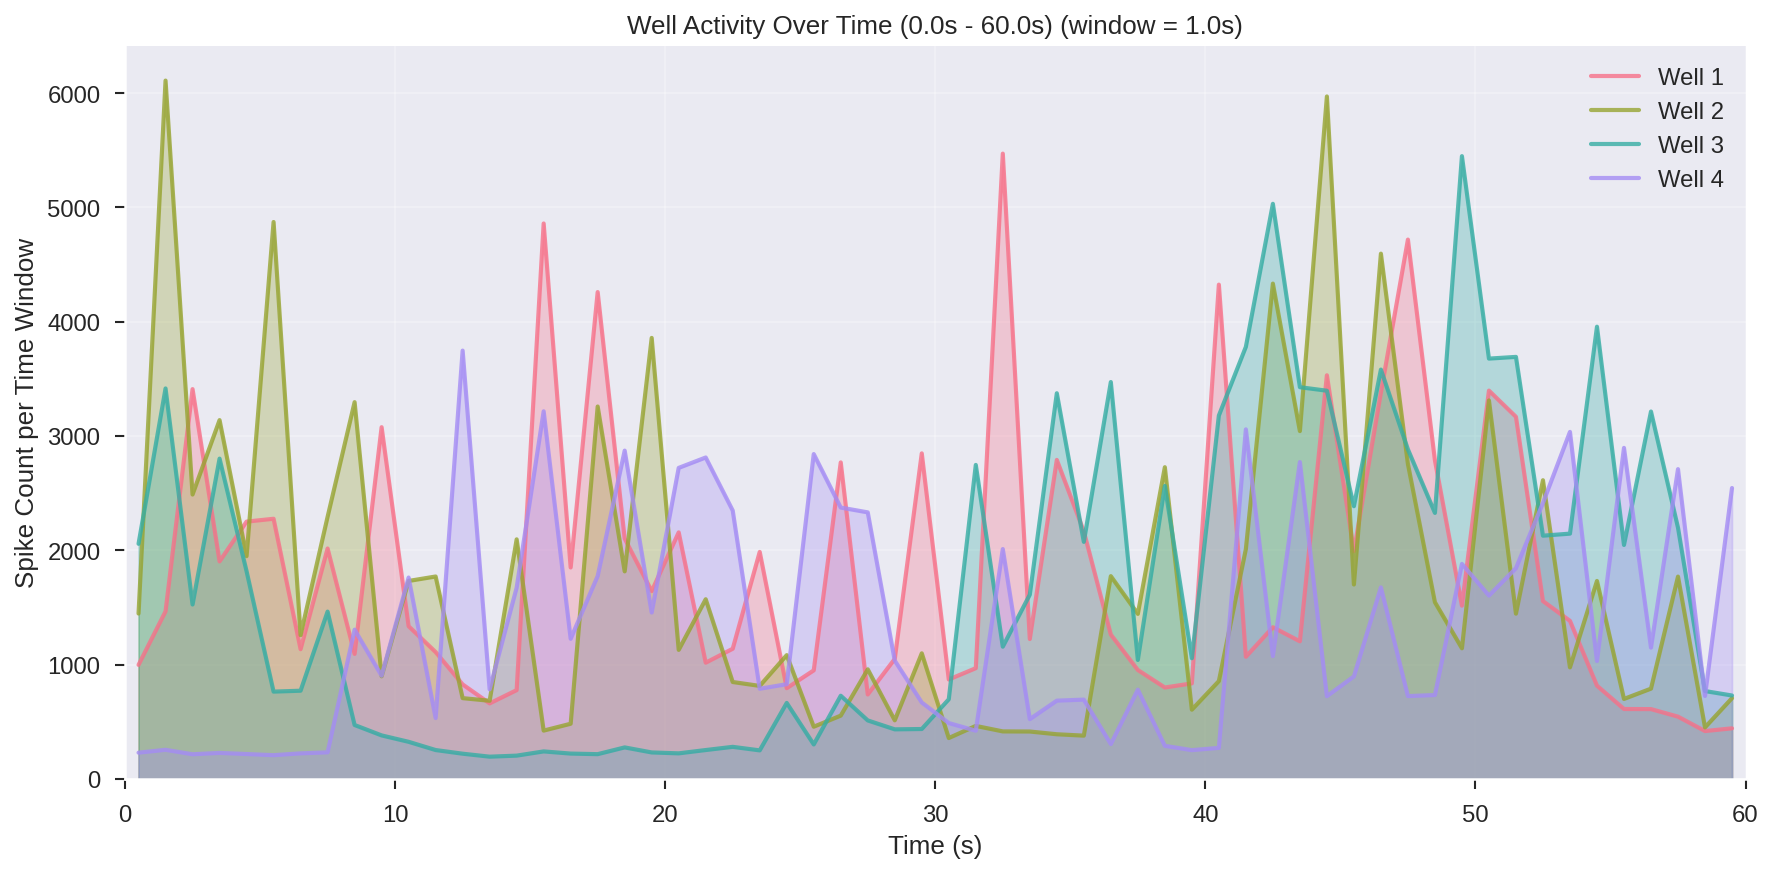

In [7]:
plotter.plot_well_activity(
    spike_lists['control'], 
    metric='spike_count', 
    time_window=1.0,
    time_range=(0, 60)
)

##### 3. Spatial electrode activity maps (`plot_electrode_map`)

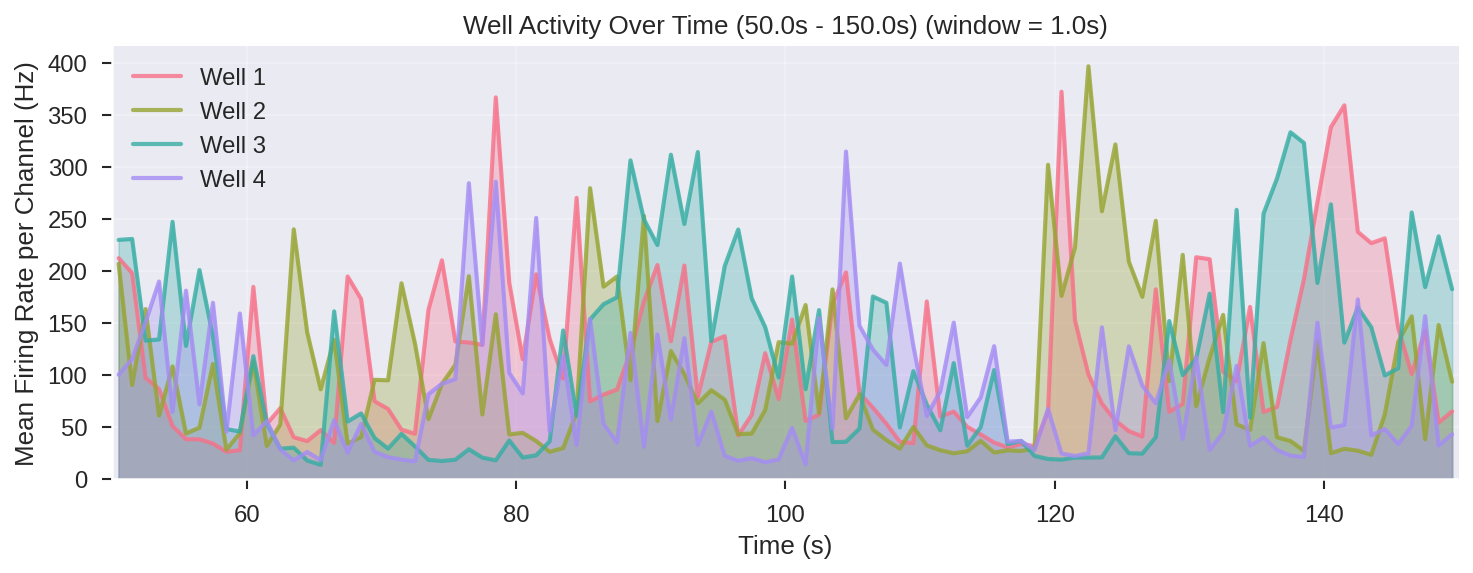

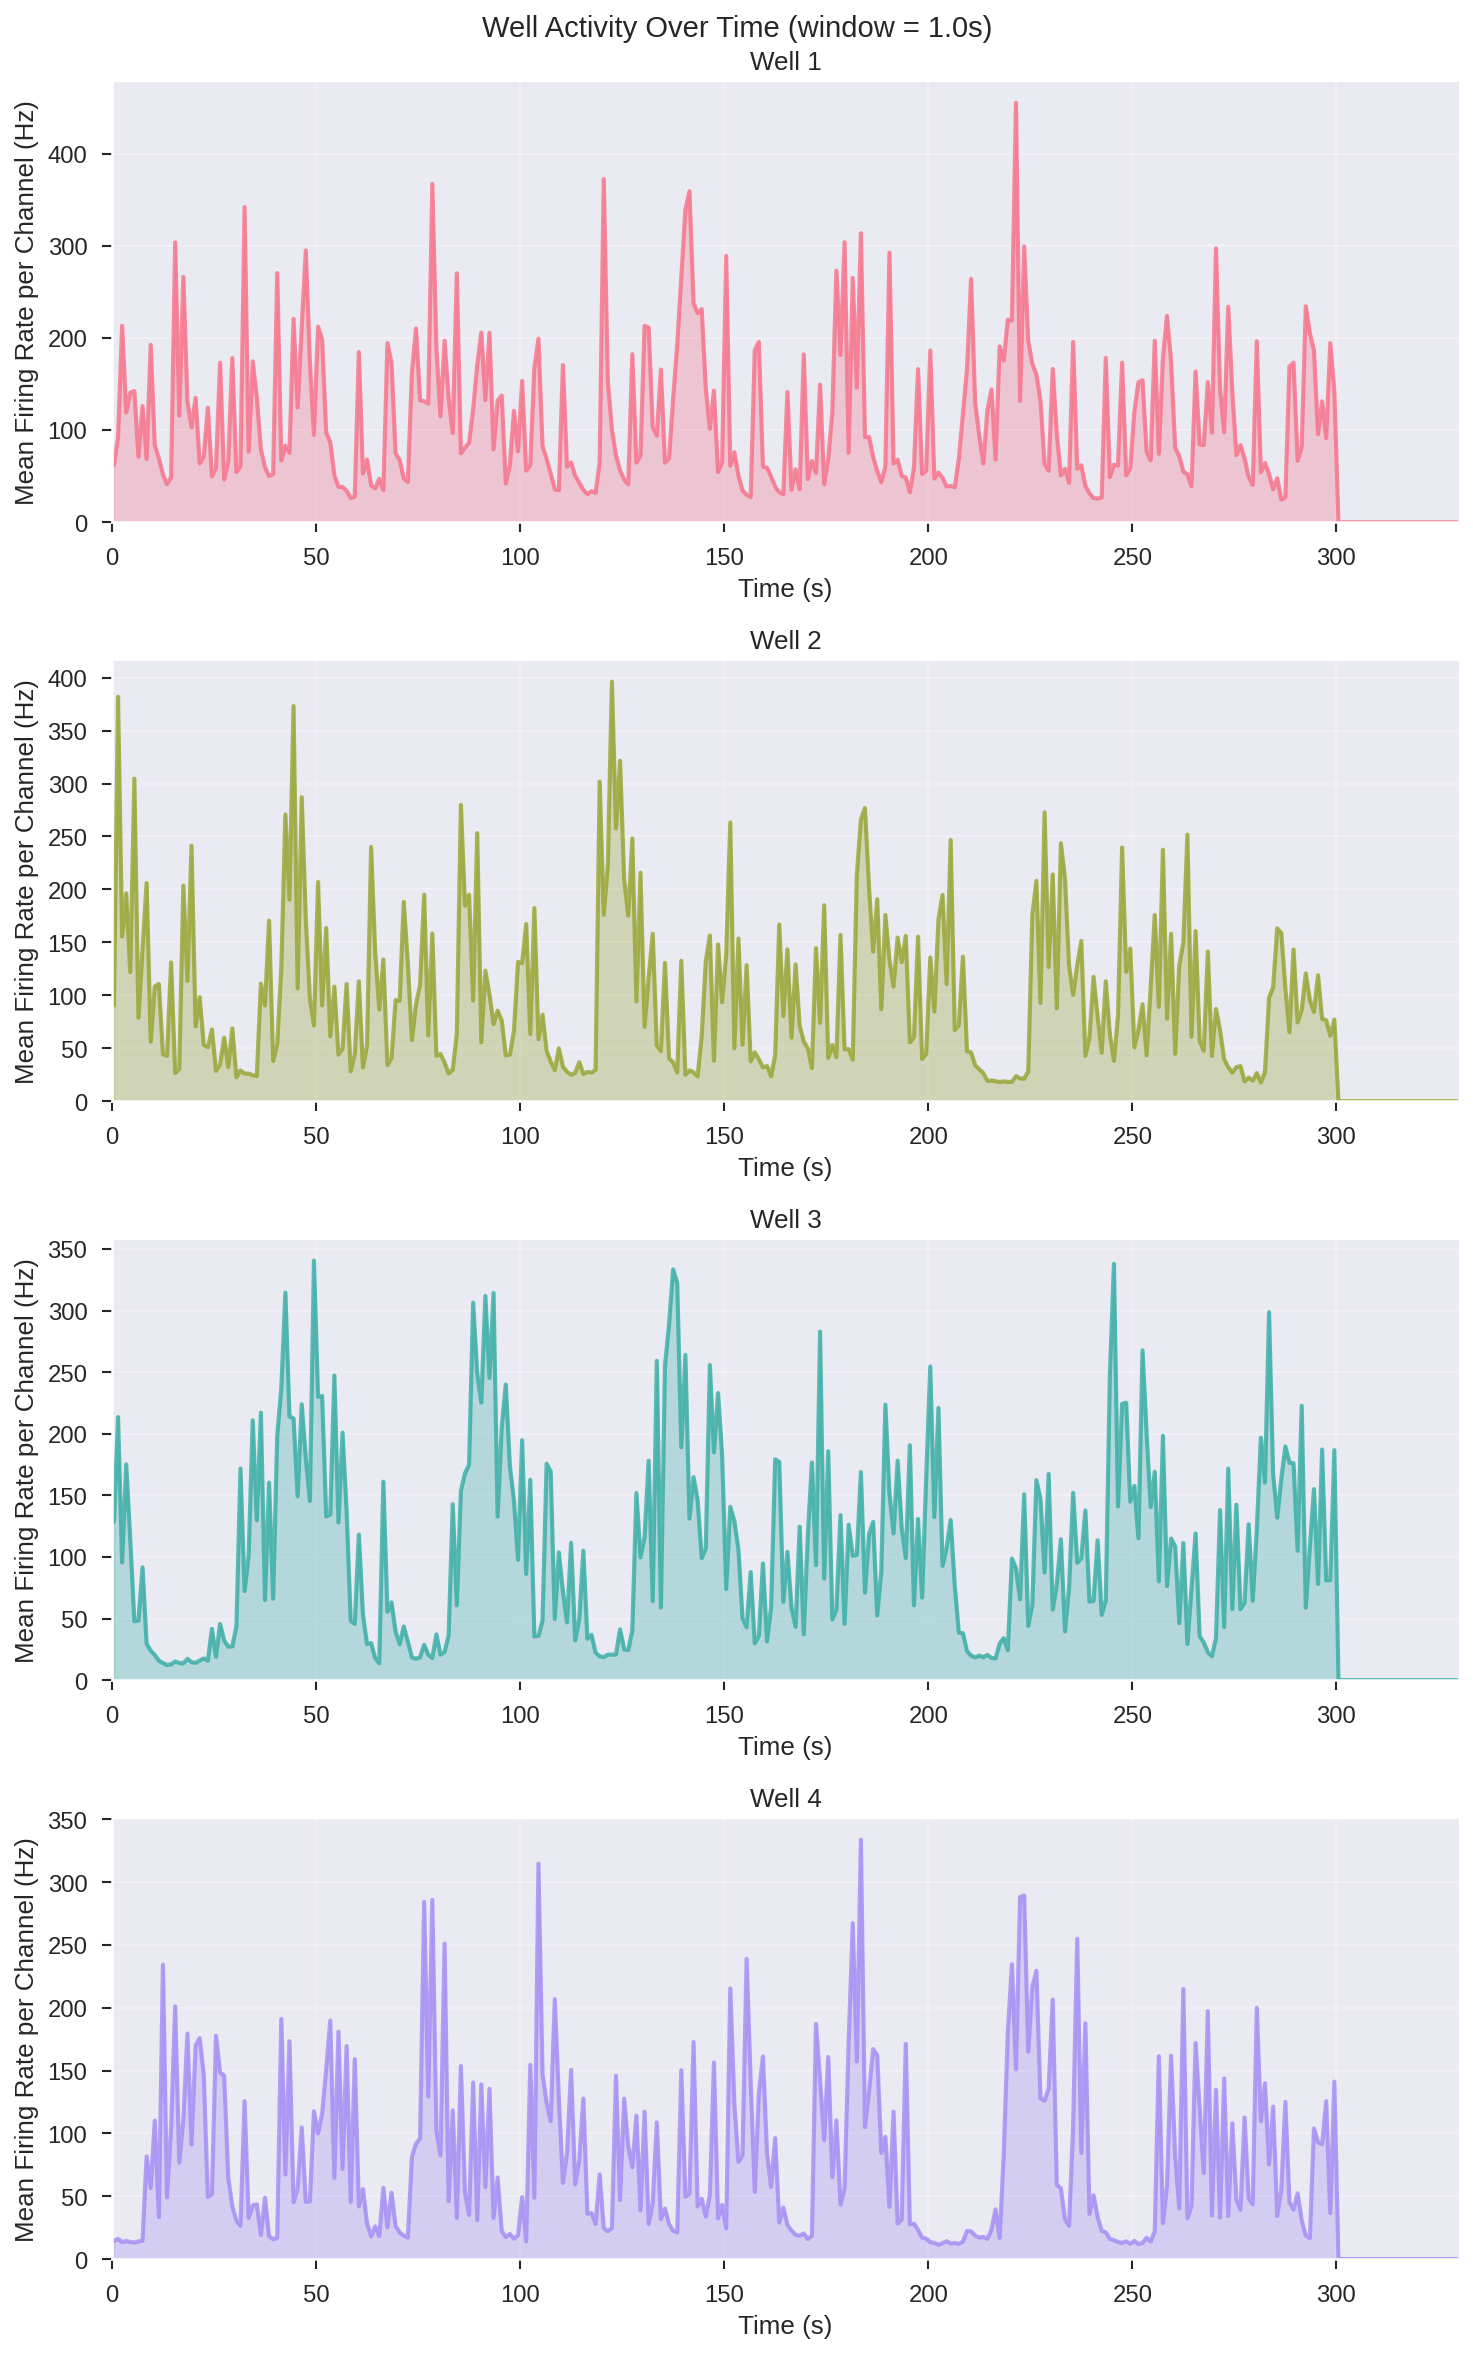

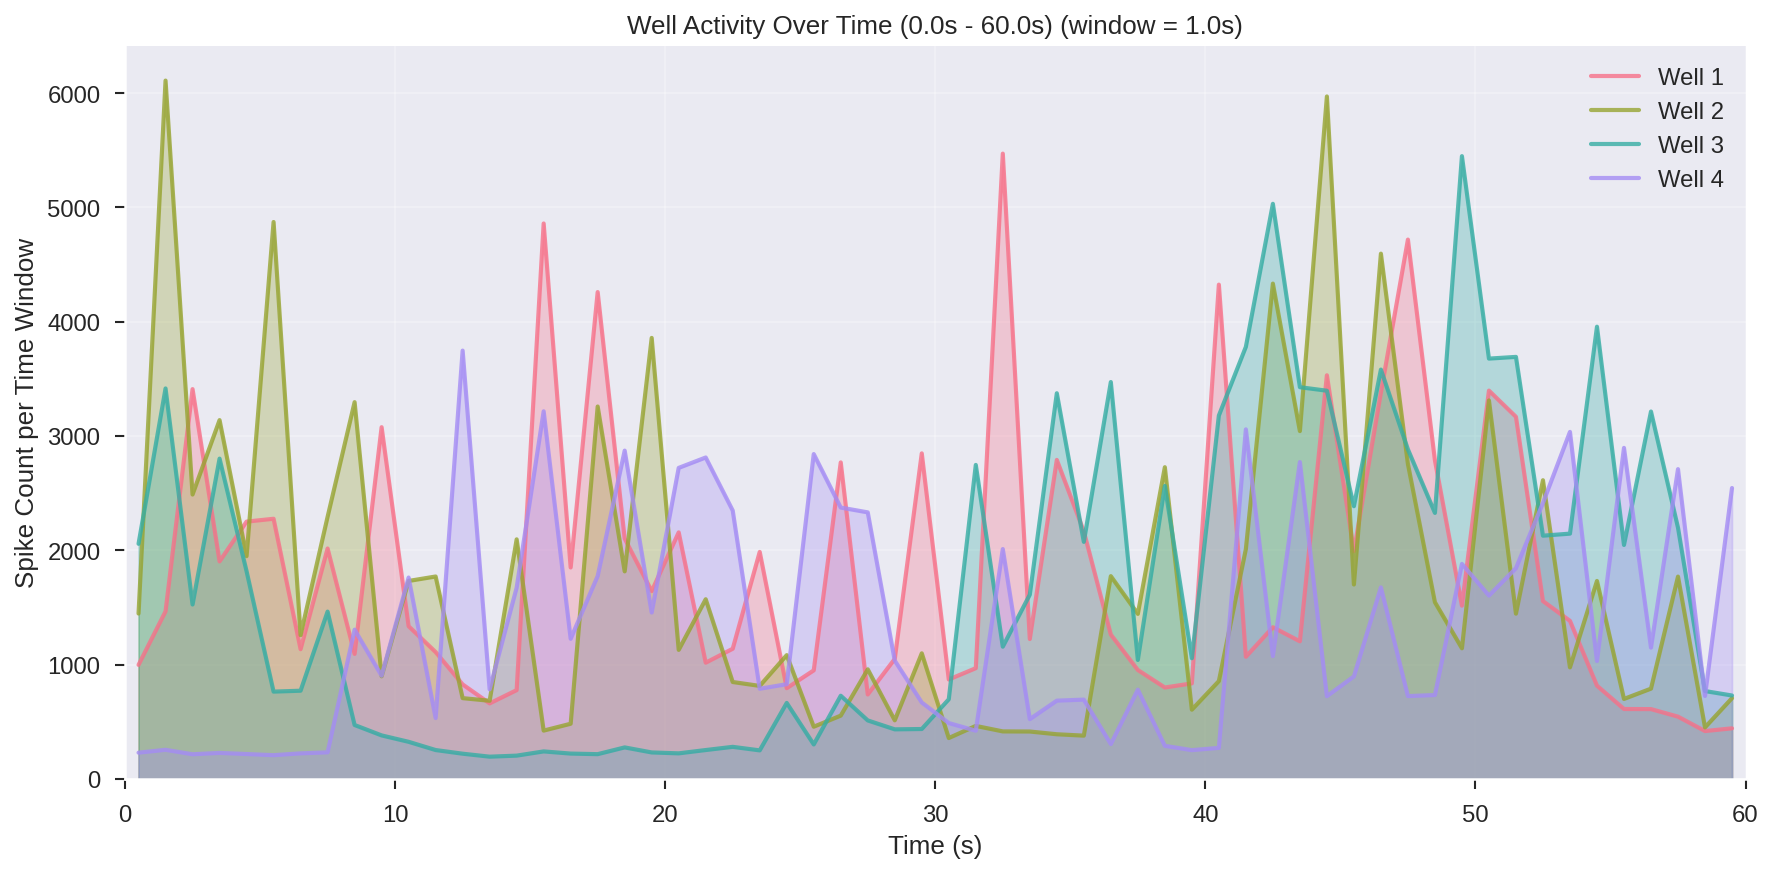

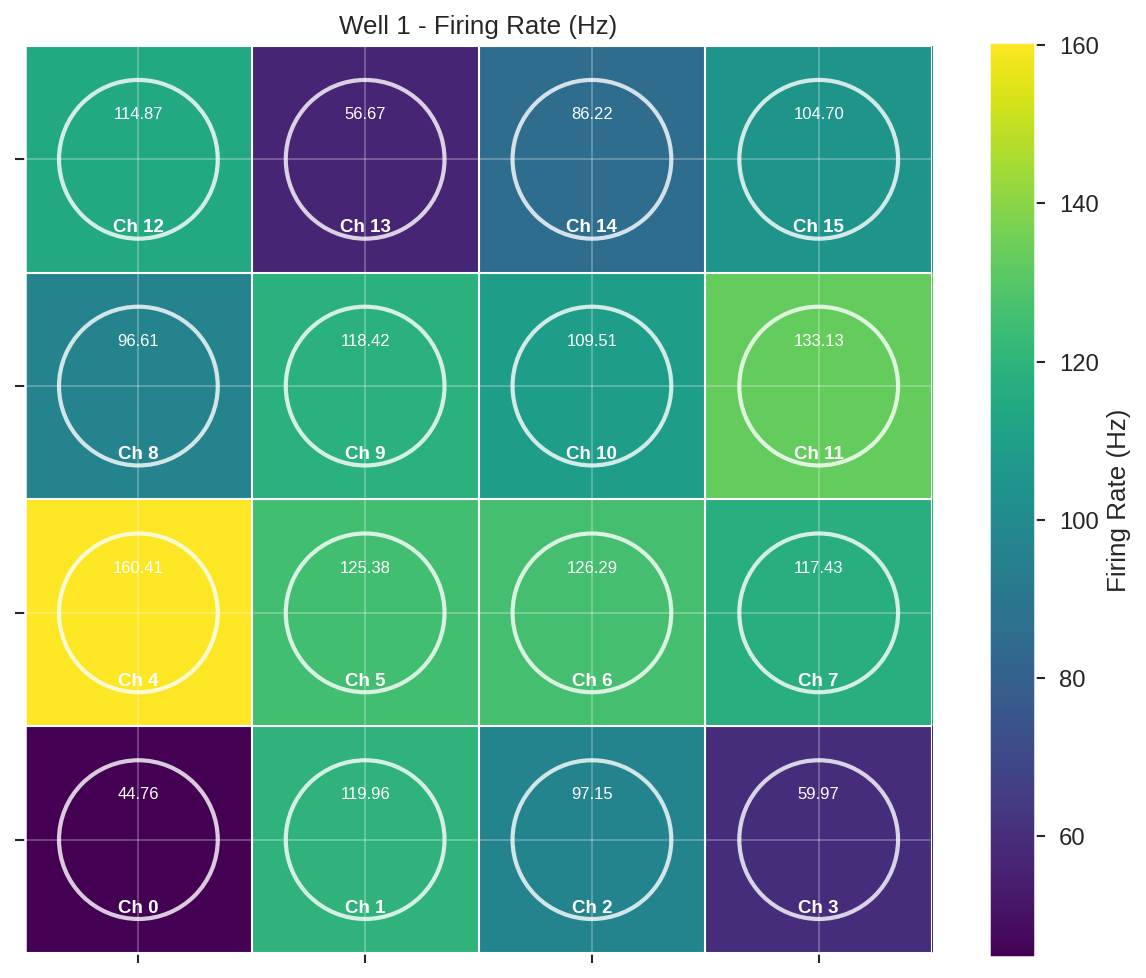

In [8]:
# Spatial activity distribution on electrode grid
# Single well with markers
fig = plotter.plot_electrode_map(spike_lists['control'], well_id=1)


/home/neuro/repos/mea-flow/src/mea_flow/visualization/wells.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


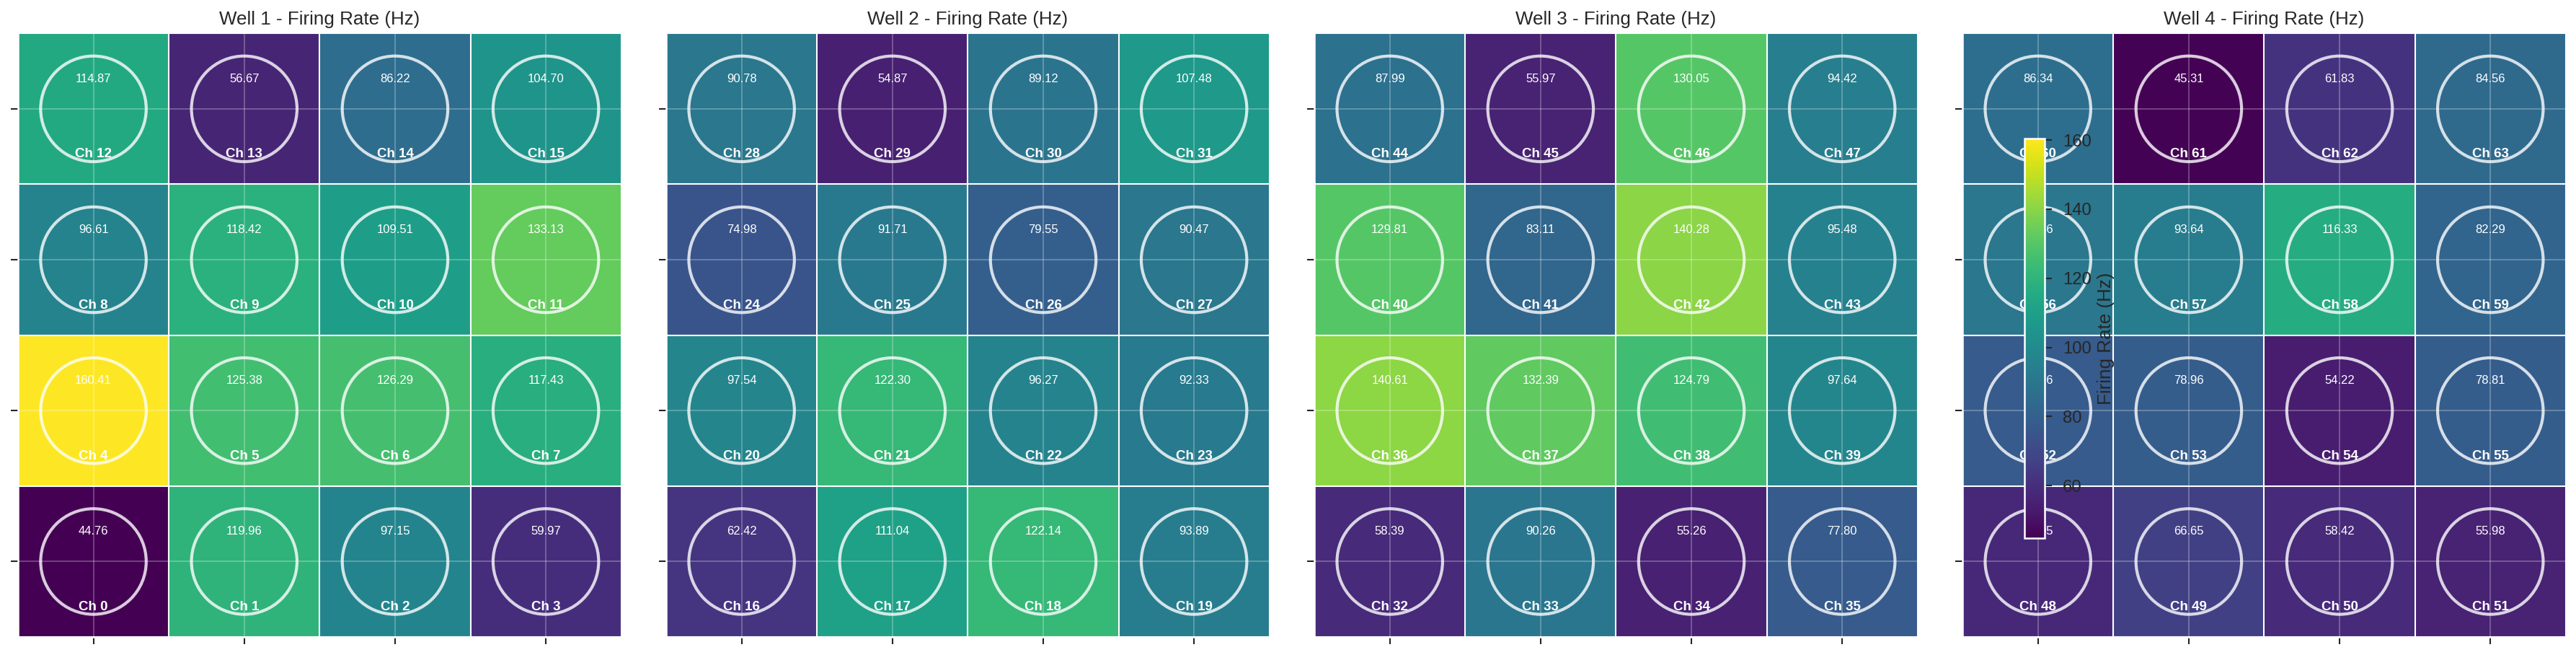

In [9]:
# All wells side by side
fig = plotter.plot_electrode_map(spike_lists['control'], all_wells=True)


/home/neuro/repos/mea-flow/src/mea_flow/visualization/wells.py:230: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


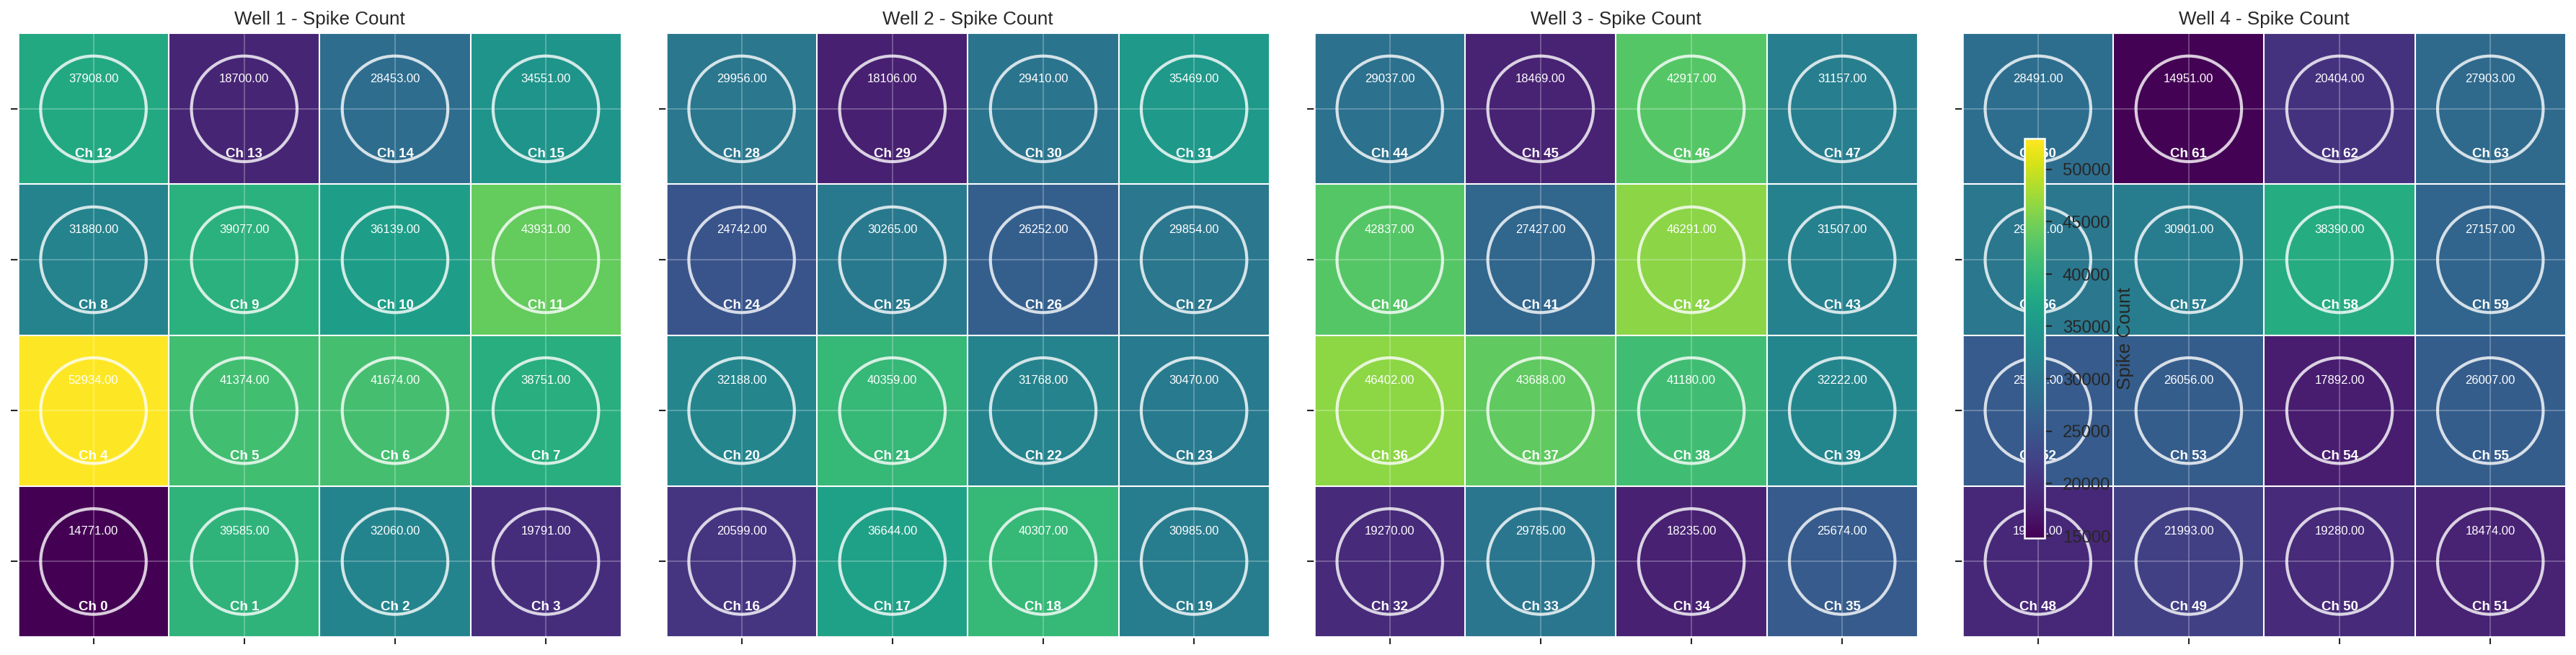

In [10]:
# Specific metric across all wells
fig = plotter.plot_electrode_map(
    spike_lists['control'], 
    metric='spike_count', # firing_rate, cv_isi, etc.
    all_wells=True,
    save_path='all_wells_spike_count.png'
)

In [11]:
from mea_flow.visualization import plot_animated_electrode_map

# Single well animation
# anim = plot_animated_electrode_map(
#     spike_lists['control'],
#     metric='firing_rate',
#     window_length=10.0,  # 10-second windows
#     step_size=2.0,       # Move 2s per frame
#     well_id=0
# )

# All wells side by side animation
# anim = plot_animated_electrode_map(
#     spike_lists['control'],
#     metric='firing_rate',
#     window_length=15.0,
#     step_size=3.0,
#     all_wells=True,      # Shows all wells horizontally
#     save_path='electrode_map_animation.mp4'
# )

##### 4. Multi-condition electrode grid (`plot_well_grid`)

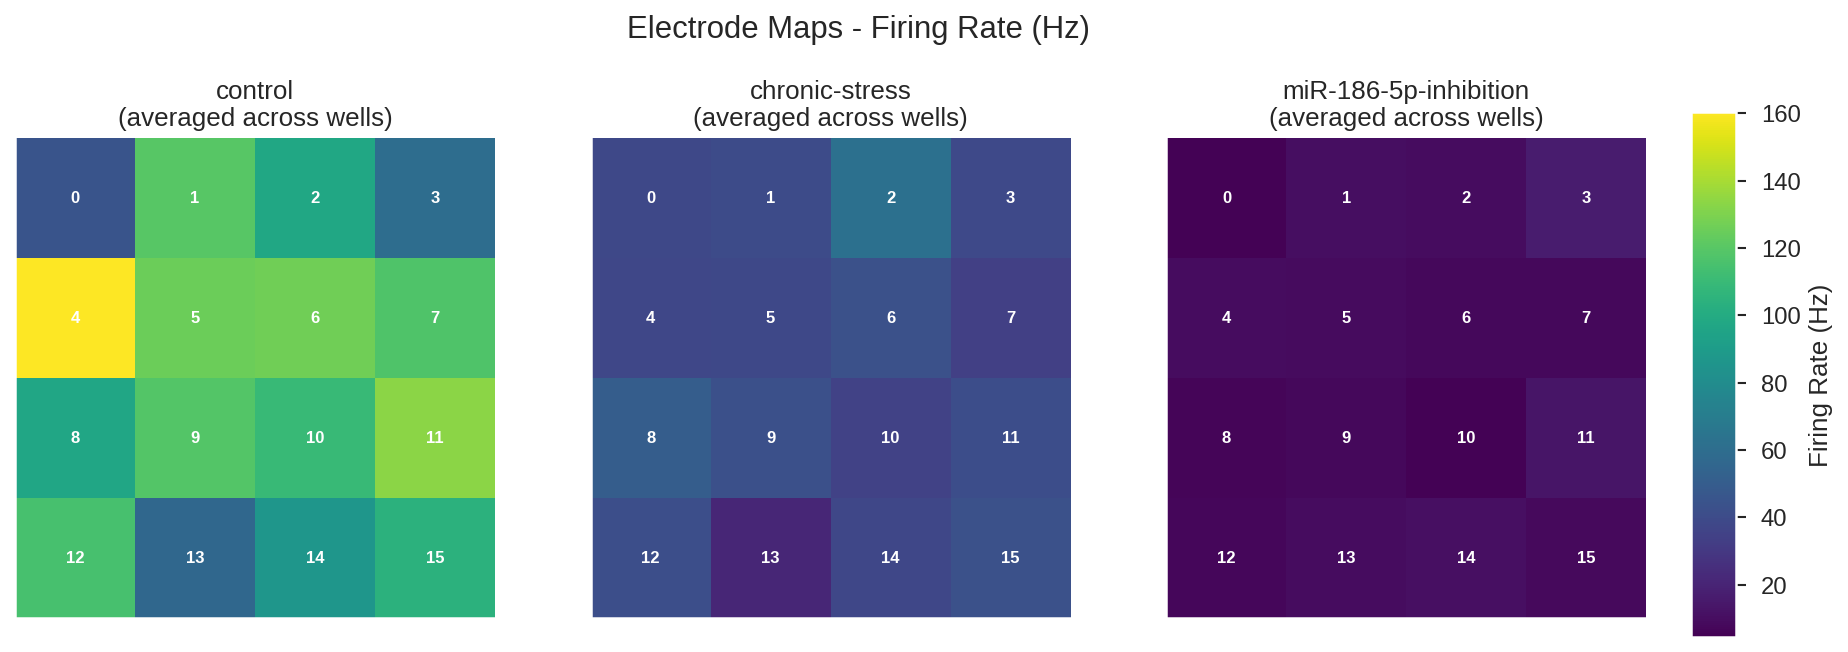

In [12]:
from mea_flow.visualization.wells import plot_well_grid

# Complete statistical comparison (recommended)
fig = plot_well_grid(
    spike_lists,
    metric='firing_rate',
    well_selection='average',
    show_std=False
)

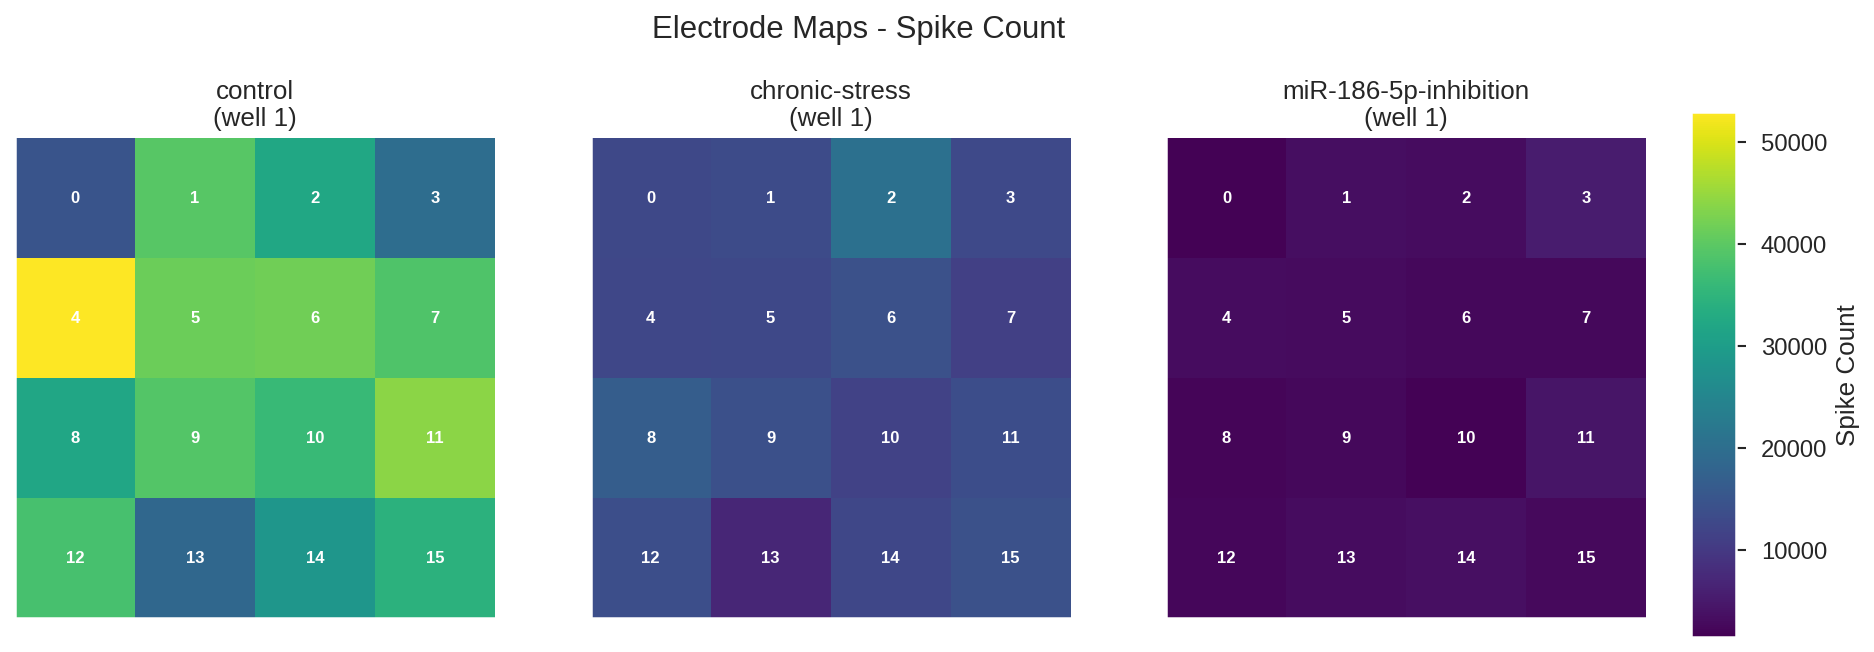

In [13]:
# Compare specific well across conditions
fig = plot_well_grid(
    spike_lists,
    well_selection='specific',
    specific_well_id=1,
    metric='spike_count'
)

##### 5. Manifold embedding (`plot_embedding`)

This is just for demo purposes, the complete and adequate application of these methods is shown in [05_manifold_analysis.ipynb](05_manifold_analysis.ipynb).

Converting spike trains to continuous signals...
   Regular sampling: 10000 timepoints (every 32 samples)
Subsampling signal matrix for embeddings: 329998 -> 50000 timepoints
   Regular sampling: every 6 timepoints
   Embedding matrix shape: (64, 50000)
Applying dimensionality reduction methods...
   Applying PCA...
Calculating effective dimensionality...


/home/neuro/repos/mea-flow/src/mea_flow/manifold/analysis.py:174: UserWarning: Failed to evaluate PCA: evaluate_embedding() got an unexpected keyword argument 'method'
  warnings.warn(f"Failed to evaluate {method}: {e}")


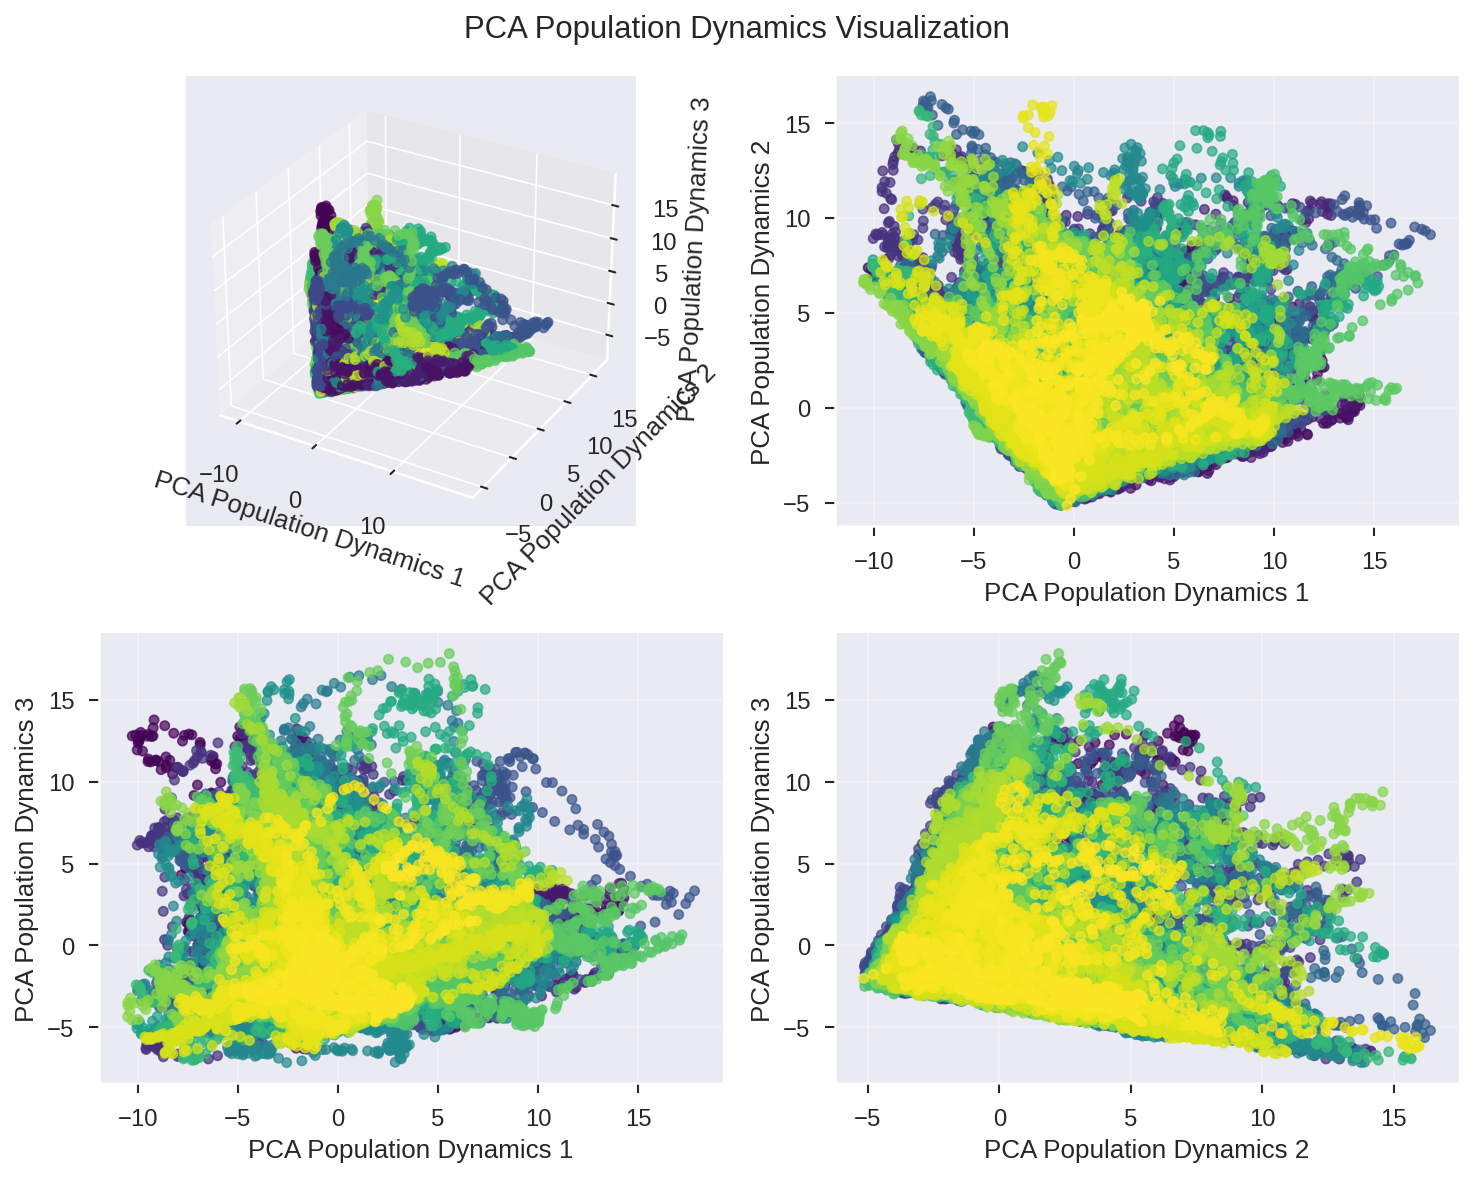

In [15]:
from mea_flow.manifold import ManifoldAnalysis, ManifoldConfig

# Custom configuration
config = ManifoldConfig(
    tau=0.02,  # Custom filter time constant
    methods=['PCA'], #, 'MDS', 'Isomap', 'LLE', 'UMAP', 't-SNE'],
    max_components=10, # max PCA components
    max_distance_samples=10000,   # downsample (memory constraints)
    use_regular_sampling=True     # Regular intervals (default) or random
)

# Run analysis with your parameters
manifold = ManifoldAnalysis(config=config)
results = manifold.analyze_population_dynamics(spike_lists['control'])

# PCA embedding
fig = plotter.plot_embedding(
    results['embeddings']['PCA']['embedding'],
    labels=None,
    method_name='PCA Population Dynamics'
)